# Plotting Examples

There are a variety of methods that can be used to visualize a network, which we demonstrate below.  For most plots, [NetworkX](https://networkx.org/) is used to create the structure of the network and [matplotlib](https://matplotlib.org/) manages the drawing.

````{tip}
You can interactively zoom and pan a network's visualization within Jupyter by installing the [ipympl](https://matplotlib.org/ipympl/) package and then adding:

```
%matplotlib widget
```

to the notebook (in a cell that is executed).
````

In [1]:
import pynucastro as pyna

## Standard view

Let's build a quick network that represents He, C, and O burning

In [2]:
library = pyna.ReacLibLibrary()

In [3]:
sub = library.linking_nuclei(["p", "n", "he4", "c12", "n13", "n14", "o16",
                              "ne20", "ne21", "na23", "mg23", "mg24", "al27",
                              "si27", "si28"])
rc = pyna.RateCollection(libraries=sub)

/home/zingale/development/pynucastro/pynucastro/networks/rate_collection.py:720: UserWarning: ReacLib neutron decay rate (<n_to_p_weak_wc12>) does not account for degeneracy at high densities. Consider using tabular rate from Langanke.
  warnings.warn(msg)


The standard network plot of this is:

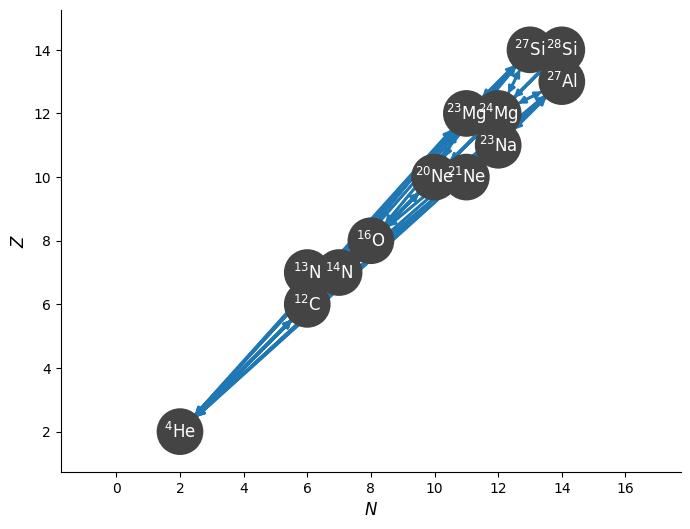

In [4]:
fig = rc.plot()

## Rotated view

Since everything lies close to the diagonal, it is hard to see the structure.  We can instead look at a rotated view of the network.

While we're at it, we'll also color the rates by reaction rate strength

In [5]:
rho = 1.e4
T = 1.e8
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

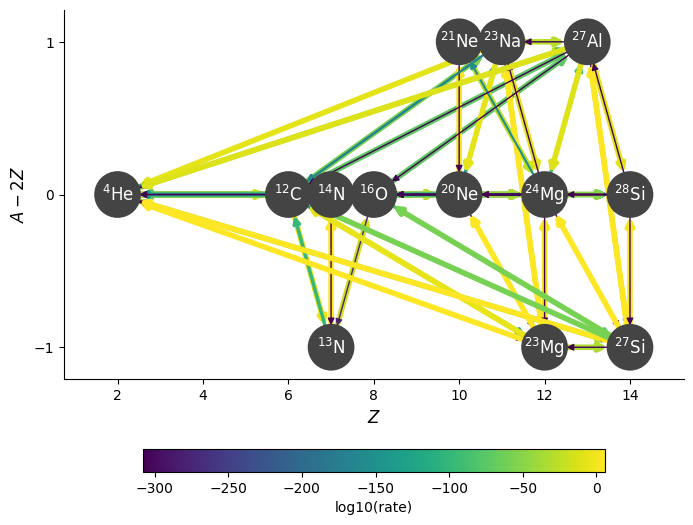

In [6]:
fig = rc.plot(rho, T, comp, rotated=True)

## Hiding links

This looks a bit crowded, since it is showing all of the links to ${}^4\mathrm{He}$ from reactions of the form $A(x, \alpha)B$.  We can hide those links with ``hide_xalpha=True``

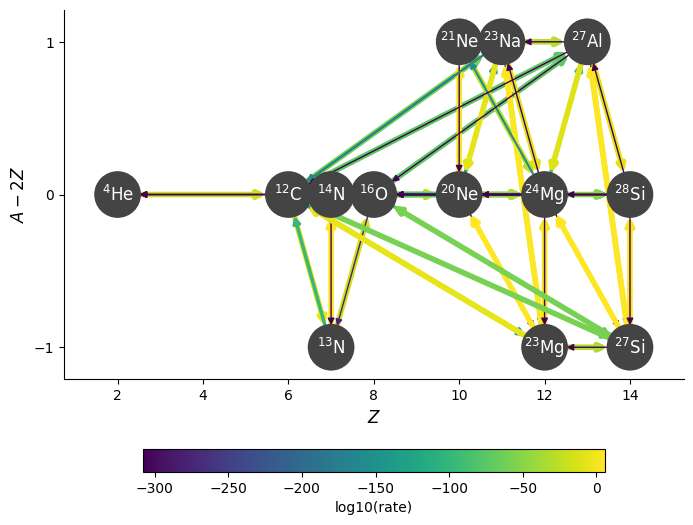

In [7]:
fig = rc.plot(rho, T, comp, rotated=True, hide_xalpha=True)

## Curved edges

We can also plot the edges curved, to help distinguish the forward and reverse rates

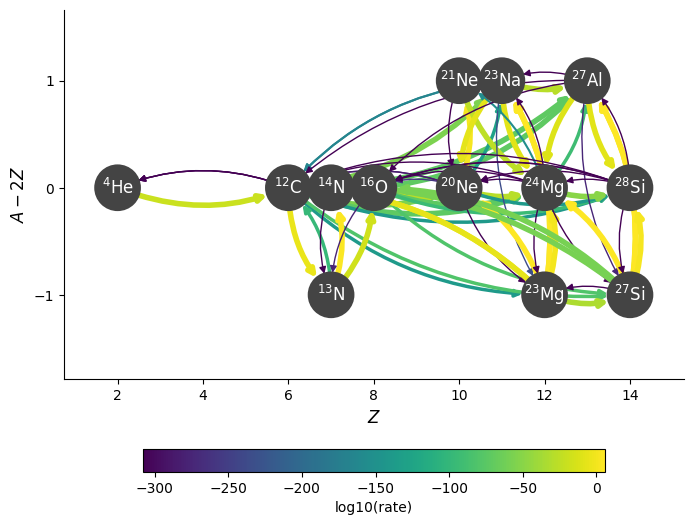

In [8]:
fig = rc.plot(rho, T, comp, rotated=True, hide_xalpha=True,
              curved_edges=True)

## Adding a legend

We can also add a "compass rose" style legend that shows the directions of key captures.  We specify the location in terms of (Z, N)

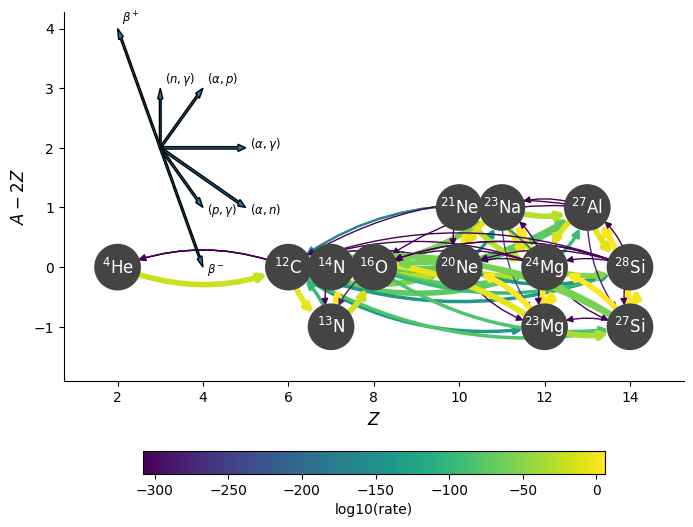

In [9]:
fig = rc.plot(rho, T, comp, rotated=True, hide_xalpha=True,
              curved_edges=True, legend_coord=(3, 2))

## Labeling edges

Any edge can be labelled.

In [10]:
edge_labels = {(pyna.Nucleus("he4"), pyna.Nucleus("c12")):
               r"$\alpha(\alpha\alpha,\gamma){}^{12}\mathrm{C}$"}

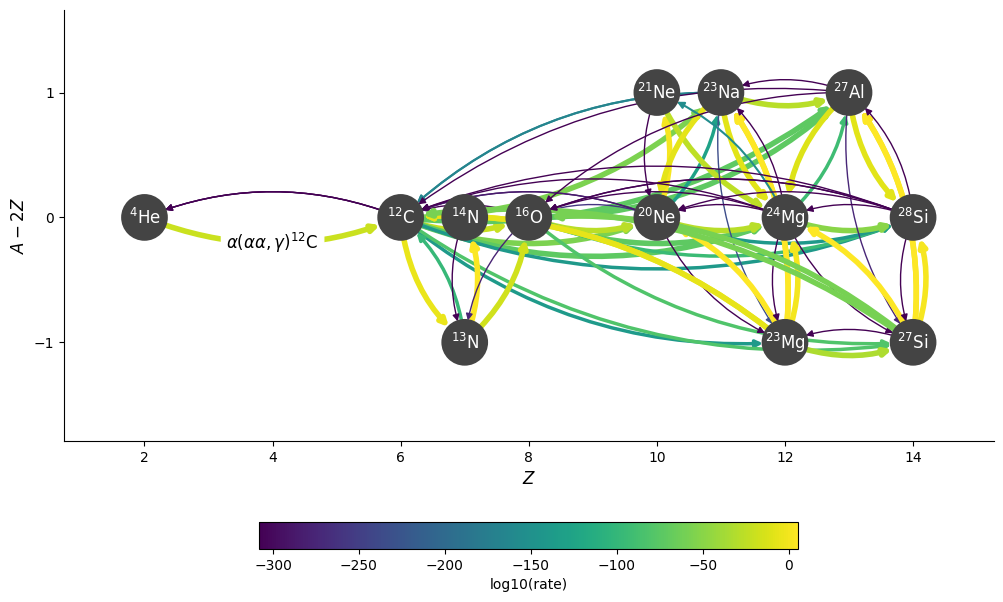

In [11]:
fig = rc.plot(rho, T, comp, rotated=True, hide_xalpha=True,
              edge_labels=edge_labels, size=(1200, 700),
              curved_edges=True)

## Filters

We can use a rate filter to show only certain links.  For example, to show only links involving proton capture, we can do:

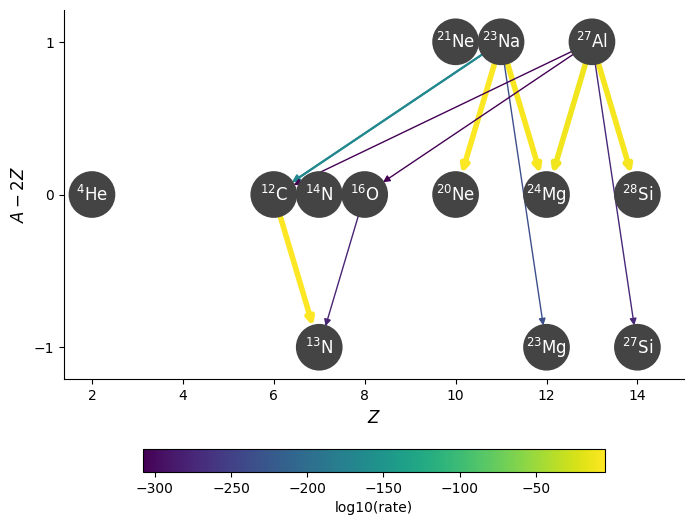

In [12]:
fig = rc.plot(rho, T, comp, rotated=True, hide_xalpha=True,
              rate_filter_function=lambda r: pyna.Nucleus("p") in r.reactants)

We can also highlight rates using the `highlight_filter_function` mechanism.  This takes a function that operates on a rate and returns `True` if we wish to highlight the rate (i.e., as if we used a highlighter marker over the line).

Here's an example where we highlight the rates that have $Q > 0$

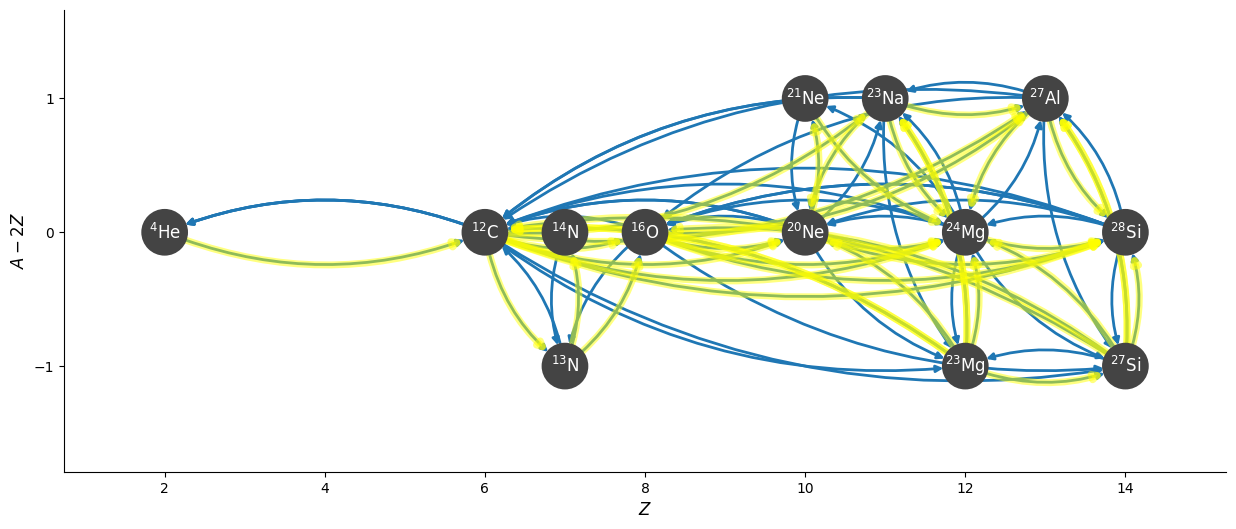

In [13]:
fig = rc.plot(rotated=True, hide_xalpha=True, size=(1500, 600),
              highlight_filter_function=lambda r: r.Q > 0,
              curved_edges=True)

## Plotting the Jacobian

For implicit integration, we solve:

$$\dot{\bf Y} = {\bf f}({\bf Y})$$

and the Jacobian, ${\bf J} = \partial {\bf f} / \partial {\bf Y}$ plays an important role
in solving for the update.

We can visualize the Jacobian of our network easily.  By default, we will show all elements
where 

$$\frac{\mathrm{max}_{i,j} (|J_{ij}|)}{|J_{ij}|} > 10^{10}$$

but this ratio can be set via the `rate_scaling` keyword argument.

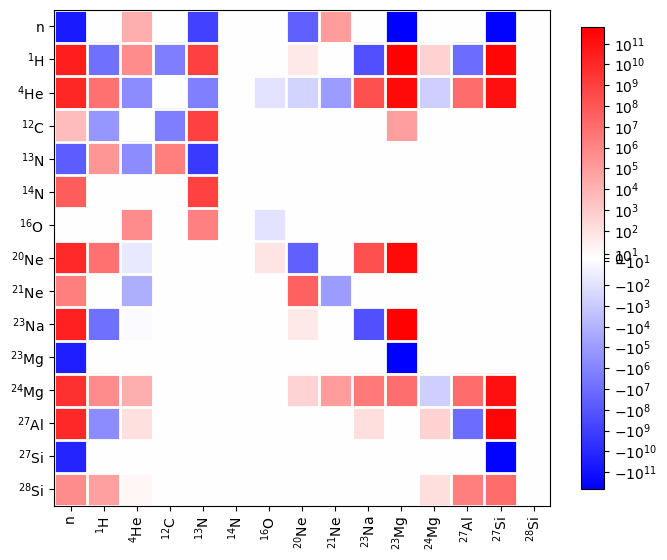

In [14]:
rho = 1.e4
T = 2.e9
comp.set_equal()
fig = rc.plot_jacobian(rho, T, comp, rate_scaling=1.e10)

```{note}
If you set `rate_scaling` too large, then roundoff error in mapping the Jacobian elements to colors can cause elements that are zero to appear colored.  It is best to stay below `1.e15` to minimize roundoff.
```

## Plot nuclides on a grid

Nuclides in a network may also be visualized as cells on a grid of Z vs. N, colored by some quantity. This can be more interpretable for large networks. 

Calling `gridplot` without any arguments will just plot the grid -- to see anything interesting we need to supply some conditions. Here is a plot of nuclide mass fraction on a log scale, with a 36 square inch figure:

In [15]:
rate_names = ["c12(p,g)n13", 
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]
rates = library.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

In [16]:
rho = 1.e4
T = 1.e8
comp = pyna.Composition(rc.get_nuclei())
comp.set_solar_like()

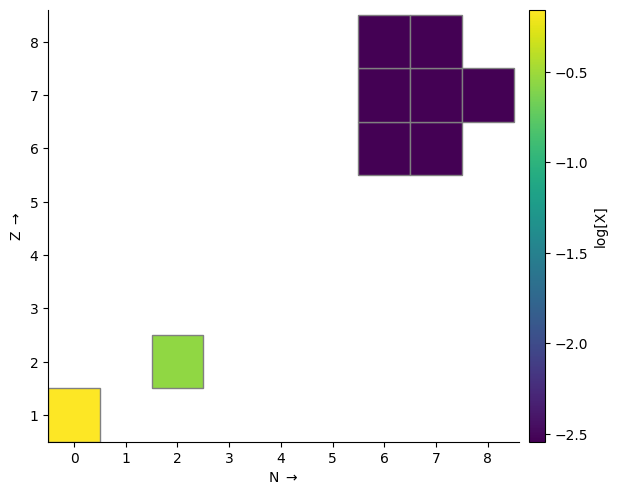

In [17]:
fig = rc.gridplot(comp=comp, color_field="X", scale="log", area=36)

The plot is configurable through a large number of keyword arguments. Here we want to look at the rates at which nuclides are being created or destroyed, so we color by $\dot{Y}$, the rate of change of molar abundance. Density and temperature need to be supplied to evaluate the rates. A full list of valid keyword arguments can be found in the API documentation.

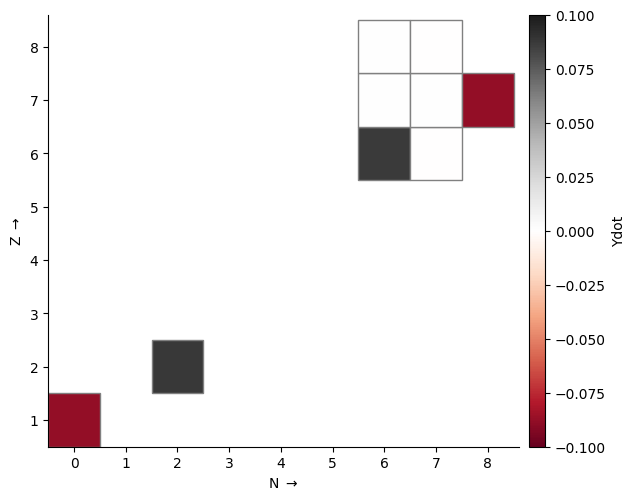

In [18]:
fig = rc.gridplot(comp=comp, rho=rho, T=T, color_field="ydot", area=36,
                  cmap="RdGy", cbar_bounds=(-0.1, 0.1))

Unlike the network plot, this won't omit hydrogen and helium by default. To just look at the heavier nuclides, we can define a function to filter by proton number.  Here we also plot
*activity*, which is the sum of all rates contributions to Ydot ignoring the sign.

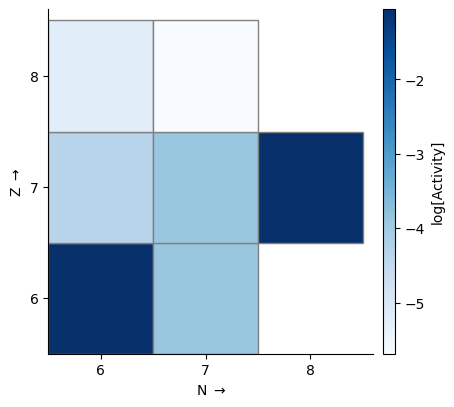

In [19]:
ff = lambda nuc: nuc.Z > 2
fig = rc.gridplot(comp=comp, rho=rho, T=T, color_field="activity", scale="log",
                  filter_function=ff, area=20, cmap="Blues")

## Network chart

A network chart shows how each rate affects each nucleus

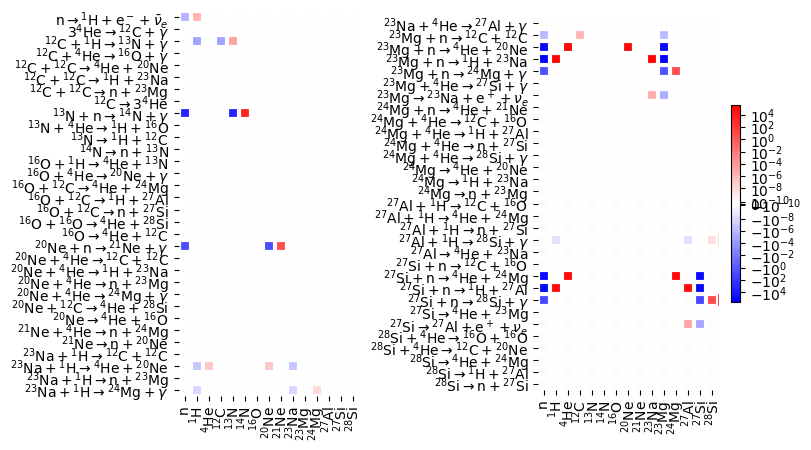

In [15]:
fig = rc.plot_network_chart(rho, T, comp)

In [16]:
G = rc.create_network_graph(rc.unique_nuclei)

In [17]:
type(G)

networkx.classes.multidigraph.MultiDiGraph